**Lin_Ucbをjaxで書いてみる** 

下のアルゴリズムはLinUCBを表しています.

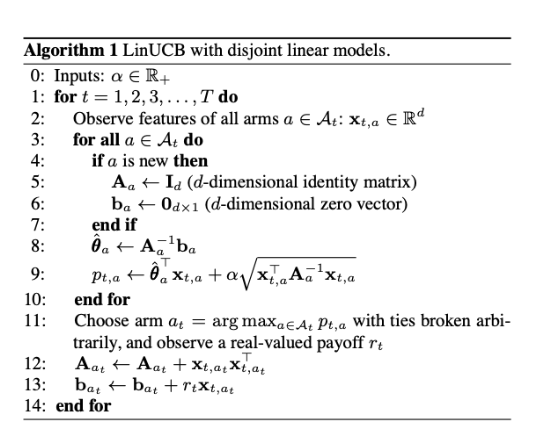

LinUCBはある環境に**特徴量**が付いており,それらを考慮して,さらに**不確かさ**まで考慮した行動選びができます．

⚠︎UCBでは**特徴量**は考慮できません．

特徴量がある環境とはしたの図のような物で,それぞれのスロットマシーンに特徴量が付随しているのがわかります.

<img src='/Users/ichiharayuuseimare/Desktop/Syumi-note/img/IMG_B280DAF0B9C6-1 (1).jpeg' width=40%>

LinUCBならこれらの特徴量をone-hot-vectorなどを使い,**報酬が最大になりそうな次の行動**を選ぶことができます．

次に特徴量を0か1で表す際の関数を定義します．

A = {花,イチゴ}


I_(A)(x) = \begin{cases}
    1 & (x \in A) \\
    0 & (x \notin A)
  \end{cases}
  



上の図の特徴量を$[I(花),I(イチゴ)]$と変換して書くと,上の図は下のような行列で書かれます．

**特徴量** = \begin{bmatrix}
    0 & 0 \\
    1 & 0 \\
    0 & 1 \\
    1 & 1 \\
\end{bmatrix}

In [7]:
arms = [[0,0],[1,0],[0,1],[1,1]]

**ここから環境の報酬の説明をしていきます**

報酬の生成される過程は各アームを選び,特徴量関数と線形予測子を掛けて,**リンク関数**というものに入れます.(ここではロジスティック関数)

ロジット関数から返ってきたものとnp.random.random()で返されるものを比較して,大きければ報酬を与えるということにします．

この報酬は上の仮定によりベルヌーイ分布に従います．

In [5]:
import numpy as np

#環境の定義
class Env:
    """
    prob(arm:int) -> 特徴量と線形予測子の掛けたものをリンク関数に入れたもの
    reward(arm:int) -> 報酬を返す
    opt_arm -> 最適なアームを返す
    """
    
    def prob(arm: int):
        x = arm[0] * 0.3 + arm[1] * 0.7 - 2
        
        prob = 1 / (1 + np.exp(-x))
        
        return prob
    
    def opt_arm():
        return np.argmax([Env.prob(arm) for arm in arms])

In [3]:
# import jax 
# import jax.numpy as jnp


# class LinUCB:
#     def __init__(self, alpha: int, sigma: int):
#         self.f_matrix = jnp.array([[arm[0],arm[1],1] for arm in arms]).T
#         self.alpha = alpha
#         self.sigma = sigma
#         self.A = jnp.identity(self.f_matrix.shape[0])
#         self.b = jnp.zeros((self.f_matrix.shape[0],1))
        
#     @jax.jit
#     def choice_arm(self):
#         inv_A = jnp.linalg.inv(self.A)
#         theta = inv_A.dot(self.b)
#         mean = self.f_matrix.T.dot(theta)
#         var = self.f_matrix.T.dot(inv_A).dot(self.f_matrix)
#         ucb = mean.T + self.alpha * jnp.sqrt(jnp.diag(var))
        
#         return np.argmax(ucb)
    
#     @jax.jit
#     def update(self,index: int, reward: int):
#         feature = self.f_matrix[:,[index]]
#         self.A = self.A + feature.dot(feature.T) / (self.sigma ** 2)
#         self.b = self.b + feature * reward / (self.sigma ** 2)

In [2]:
import jax.numpy as jnp
import jax

In [13]:
f_matrix = jnp.array([[arm[0],arm[1],1] for arm in arms]).T
b = jnp.zeros((f_matrix.shape[0],1))
A = jnp.identity(f_matrix.shape[0])

In [24]:
@jax.jit
def choice_arm(A, b, f_matrix, alpha):
    inv_A = jnp.linalg.inv(A)
    theta = inv_A.dot(b)
    mean = f_matrix.T.dot(theta)
    var = f_matrix.T.dot(inv_A).dot(f_matrix)
    ucb = mean.T + alpha * jnp.sqrt(jnp.diag(var))
    return np.argmax(ucb)

@jax.jit
def update(A,b,f_matrix, index: int, reward: int, sigma: int):
    feature = f_matrix[:,[index]]
    A = A + feature.dot(feature.T) / (sigma ** 2)
    b = b + feature * reward / (sigma ** 2)

次に結果の図を示していきます

In [20]:
n_steps = 5000
selected_arms = jnp.zeros((n_steps),dtype=int)
rewards = jnp.zeros((n_steps),dtype=int)

In [21]:
# def act_bandit(n_steps :int, alpha: int, sigma: int):
#     agent = LinUCB(alpha,sigma)
#     def backup(agent):
#         arm_index = agent.choice_arm()
#         reward = Env.prob(arms[arm_index])
#         agent.update(arm_index,reward)
#         selected_arms = jnp.append(selected_arms,arm_index)
#         rewards = jnp.append(rewards,reward)
    
#     body_fn = lambda i,agent:backup(agent)
#     return jax.lax.fori_loop(0,n_steps,body_fn,agent)

In [29]:
from tqdm import tqdm
for i in tqdm(range(n_steps)):
    arm_index = choice_arm(A,b,f_matrix,alpha=1.0)
    reward = Env.prob(arms[arm_index])
    update(A,b,f_matrix,arm_index,reward,sigma=1.0)
    selected_arms = jnp.append(selected_arms,arm_index)
    rewards = jnp.append(rewards,reward)


100%|██████████| 5000/5000 [02:50<00:00, 29.25it/s]


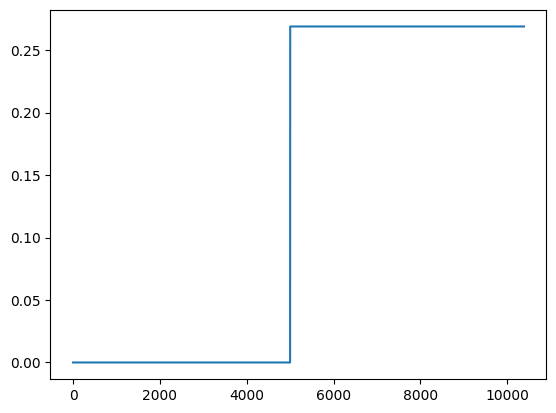

In [34]:
import matplotlib.pyplot as plt

plt.plot(rewards)